# Real Cube: Motion Extraction & Mode Identification
This notebook shows how to extract image-space modal observations from a video of the real Jello cube. There are three videos of the real cube, each of a different initial condition:
1. `real_data/jello_cube/top_front_pluck/top_front_pluck-4000fps.avi`
2. `real_data/jello_cube/top_right_pluck/top_right_pluck-4000fps.avi`
3. `real_data/jello_cube/left_side_twist/left_side_twist-4000fps.avi`

This notebook will write a `modal_observations.pkl` file, which contains images of the identified image-space modes (in the horizontal and vertical directions) and their frequencies. It will also ask you to click on the locations of reference mesh points and save them in a `clicks.npy` file. These reference points will be used to sample image-space modes at visible mesh vertices in the `demo_real_cube_inference.ipynb` notebook.

In order to recreate Fig. 11, you will need to run this notebook entirely for each of the three videos.

In [2]:
import os
import pickle
import time

import cv2
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

from utils import (read_frames, extract_motion, weighted_gaussian_smooth,
                   get_fft_results, find_peak_idxs, prompt_clicks,
                   get_cube_model, keypoints_from_clicks, gather_image_space_modes,
                   get_observed_modal_data, get_solver)
from utils import (plot_motion_field, find_nearest, normalize_modes,
                   interpolate_2d_motion, freqs_to_eigvals, projection_matrix_from_keypoints,
                   full_mode_matrix, weighted_sum, project_and_interpolate_motion,
                   plot_3d_cube)
from utils import gather_modal_data_across_videos

videos = ['top_front_pluck', 'top_right_pluck', 'left_side_twist']
fps = 4000

In [5]:
"""
Set which video to work with.
"""
video = 'top_right_pluck'
assert video in VIDEOS

N_THREADS = 8  # num. threads to use in multithreaded functions

## Motion Extraction

Reading AVI: real_data/jello_cube/top_right_pluck/top_right_pluck-4000fps.avi


Reading frames: 100%|█████████████████████████████████████████████████████████████████████████████████████| 13401/13401 [00:02<00:00, 4980.90it/s]


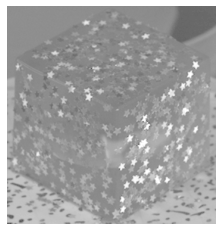

In [13]:
"""
Read the frames and show the first frame of the video.
"""
avi_fn = 'real_data/jello_cube/%s/%s-%dfps.avi' % (video, video, FPS)
print('Reading AVI:', avi_fn)

frames = read_frames(avi_fn)
plt.imshow(frames[0], cmap='gray')
plt.axis('off')
plt.show()

In [6]:
"""
Run motion extraction and then apply amplitude-weighted Gaussian smoothing to the 
displacement fields.
"""
# Some videos have large motion at the beginning, so we have to start from a later frame.
start_frames = {
    'top_front_pluck': 1000,
    'top_right_pluck': 1000,
    'left_side_twist': 0
}
t_start, t_end = start_frames[video], len(frames)
ref_frame = frames[t_start]
motion_fields = extract_motion(
    frames[t_start:t_end], ref_frame, filter_pct=98, n_threads=N_THREADS)
motion_fields = weighted_gaussian_smooth(
    motion_fields, ref_frame, sigma=4, n_threads=N_THREADS)

Running motion extraction in 8 threads...
[Thread 0] 100 / 1550 frames processed in 9.0 seconds.
[Thread 0] 200 / 1550 frames processed in 9.0 seconds.
[Thread 0] 300 / 1550 frames processed in 9.0 seconds.
[Thread 0] 400 / 1550 frames processed in 9.1 seconds.
[Thread 0] 500 / 1550 frames processed in 9.0 seconds.
[Thread 0] 600 / 1550 frames processed in 9.3 seconds.
[Thread 0] 700 / 1550 frames processed in 9.5 seconds.
[Thread 0] 800 / 1550 frames processed in 9.1 seconds.
[Thread 0] 900 / 1550 frames processed in 8.9 seconds.
[Thread 0] 1000 / 1550 frames processed in 8.9 seconds.
[Thread 0] 1100 / 1550 frames processed in 9.3 seconds.
[Thread 0] 1200 / 1550 frames processed in 9.2 seconds.
[Thread 0] 1300 / 1550 frames processed in 9.0 seconds.
[Thread 0] 1400 / 1550 frames processed in 9.0 seconds.
[Thread 0] 1500 / 1550 frames processed in 8.9 seconds.
Done! Elapsed time: 0:02:20.717473
Running amplitude-weighted Gaussian smoothing in 8 threads...
[Thread 0] 500 / 1550 frames p

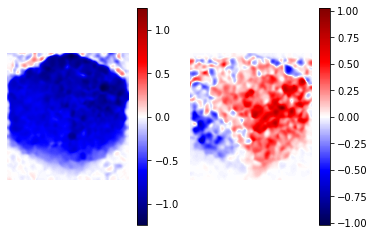

In [12]:
"""
View the displacement field at one frame.
"""
t = 1200
plt.subplot(121)
plot_motion_field(motion_fields[0][t])
plt.subplot(122)
plot_motion_field(motion_fields[1][t])

## Mode Identification

In [14]:
"""
Run 1D FFT on displacement fields.
`fft_dx[i]` contains the FFT coefficients of horizontal motion at FFT bin i.
`fft_dy[i]` contains the FFT coefficients of vertical motion at FFT bin i.
`spectrum` is the power spectrum of horizontal + vertical motion amplitude.
`ffreqs[i]` is the frequency [Hz] of FFT bin i.
"""
max_fft_freq = 50  # max. frequency (in Hz) to consider
fft_dx, fft_dy, spectrum, ffreqs = get_fft_results(
    motion_fields, fps, max_fft_freq, n_threads=N_THREADS)
log_spectrum = np.log(spectrum)

Running FFT in 8 threads...
[Thread 0] 5 / 36 rows processed in 6.2 seconds.
[Thread 0] 10 / 36 rows processed in 6.2 seconds.
[Thread 0] 15 / 36 rows processed in 6.2 seconds.
[Thread 0] 20 / 36 rows processed in 6.2 seconds.
[Thread 0] 25 / 36 rows processed in 6.2 seconds.
[Thread 0] 30 / 36 rows processed in 6.2 seconds.
[Thread 0] 35 / 36 rows processed in 6.2 seconds.
Done! Elapsed time: 0:00:44.761444


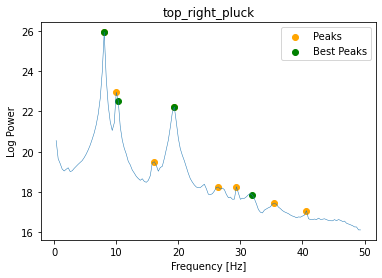

In [19]:
"""
Find peaks in the log-power spectrum of motion amplitude.
`best_peak_idxs_per_video` contains the best peaks that were
selected qualitatively.
"""
best_peak_idxs_per_video = {
    'top_front_pluck': [21, 25, 59],
    'top_right_pluck': [25, 32, 60, 99,],
    'left_side_twist': [25, 31, 65],
}
max_fft_idx = find_nearest(ffreqs, max_fft_freq)
peak_idxs = find_peak_idxs(log_spectrum[:max_fft_idx], prominence=0.01)
best_peak_idxs = best_peak_idxs_per_video[video]

plt.plot(ffreqs[1:max_fft_idx], log_spectrum[1:max_fft_idx], linewidth=0.5)
plt.scatter(
    ffreqs[peak_idxs], log_spectrum[peak_idxs], color='orange',
    label='Peaks')
plt.scatter(
    ffreqs[best_peak_idxs], log_spectrum[best_peak_idxs], color='green',
    label='Best Peaks')
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel('Log Power')
plt.title(video)
plt.show()

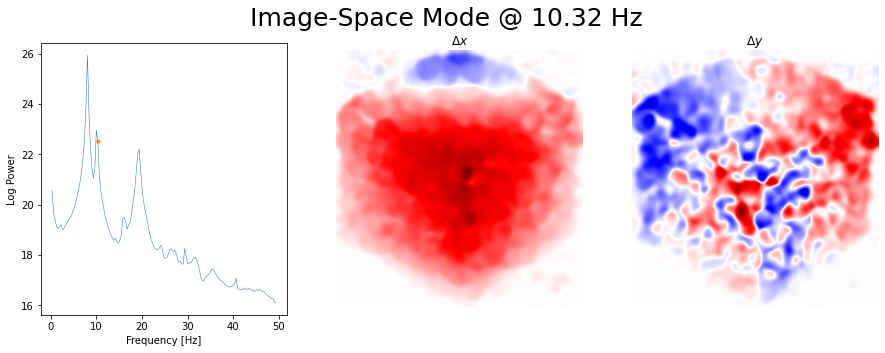

In [20]:
"""
View a specified image-space mode.
"""
fft_idx = best_peak_idxs[1]

mode_shape_dx = fft_dx[fft_idx].real
mode_shape_dy = fft_dy[fft_idx].real
mode_freq = ffreqs[fft_idx]

fig = plt.figure(figsize=(15, 5))
fig.suptitle('Image-Space Mode @ %.2f Hz' % mode_freq, fontsize=25)

plt.subplot(131)
plt.plot(ffreqs[1:max_fft_idx], log_spectrum[1:max_fft_idx], linewidth=0.5)
plt.scatter(ffreqs[fft_idx], log_spectrum[fft_idx], c='orange', s=10)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Log Power')

plt.subplot(132)
plot_motion_field(mode_shape_dx, cbar=False)
plt.title('$\Delta$$x$')
plt.axis('off')

plt.subplot(133)
plot_motion_field(mode_shape_dy, cbar=False)
plt.title('$\Delta$$y$')
plt.axis('off')
plt.show()

In [25]:
"""
Take the image-space modes at the best peaks, and save them as
modal observation data.
"""
extracted_modes_dx = np.array([fft_dx[i] for i in best_peak_idxs])
extracted_modes_dy = np.array([fft_dy[i] for i in best_peak_idxs])
extracted_freqs = ffreqs[best_peak_idxs]

data_dict = {
    'modes_dx': extracted_modes_dx,
    'modes_dy': extracted_modes_dy,
    'freqs': extracted_freqs
}

modal_data_file = 'real_data/jello_cube/%s/modal_observations.pkl' % video
with open(modal_data_file, 'wb') as fp:
    pickle.dump(data_dict, fp)
print('Wrote:', modal_data_file)

Wrote: real_data/jello_cube/top_right_pluck/modal_observations.pkl


## Reference Keypoints
We will need the pixel locations of reference mesh points (i.e., the 7 visible corners).
Click the following points in the exact order:
1. bottom left
2. bottom middle
3. bottom right
4. top left back
5. top left front
6. top right back
7. top right front

<IPython.core.display.Javascript object>


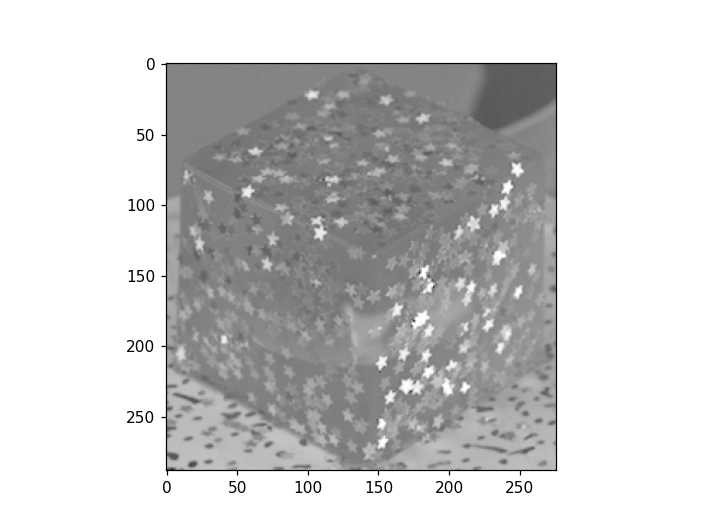

In [27]:
"""
Click on the locations of the 7 reference points.
"""
%matplotlib notebook
clicks = []
prompt_clicks(ref_frame, clicks, cmap='gray')

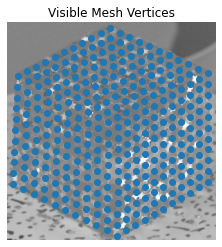

In [33]:
"""
Save the clicked locations and view them on a video frame.
"""
np.save('real_data/jello_cube/%s/clicks.npy' % video, clicks)
keypoints = keypoints_from_clicks(clicks, 10, 10, 10)

plt.close('all')
%matplotlib inline
plt.imshow(ref_frame, cmap='gray')
plt.scatter(keypoints[:, 0], keypoints[:, 1])
plt.axis('off')
plt.title('Visible Mesh Vertices')
plt.show()

In [34]:
with open('real_data/jello_cube/%s/info_dict_10x10x10_deg1.pkl' % video, 'rb') as fp:
    ref = pickle.load(fp)